# Ising - Schelling


En el modelo de Ising, tal como se presenta en el libro de Werner Krauth, se utiliza la distribución de Boltzmann para el observable macroscópico $E$, la temperatura y el $C_v$ que va a depender de la temperatura y los valores esperados de $E$ y $E^2$. Además, se mide la magnetización global $M = \sum_k \sigma_k$. El resumen de aquello es:

E = -J \sum_{<k, l>} \sigma_k\sigma_l

$$Z = \sum_E\mathcal{N}(E)e^{-\beta E}$$

$$<E> = \frac{\sum_{\sigma}E_{\sigma}e^{-\beta E_{\sigma}}}{\sum_{\sigma}e^{-\beta E_{\sigma}}} =
\frac{1}{Z}\sum_{E}E\mathcal{N}(E)e^{-\beta E}$$

$$
<E>^2 = \frac{\sum_{\sigma}E^2_{\sigma}e^{-\beta E_{\sigma}}}{\sum_{\sigma}e^{-\beta E_{\sigma}}} =
\frac{1}{Z}\sum_{E}E^2\mathcal{N}(E)e^{-\beta E}
$$

$$
C_v = \frac{\partial <E>}{\partial T} = \frac{\partial \beta}{\partial T}\frac{\partial <E>}{\partial \beta} = -\beta^2\frac{\partial <E>}{\partial \beta}
$$

$$
C_v = \beta^2\frac{\partial^2}{\partial^2 \beta}\log Z
$$

$$
c_v = \frac{\beta^2}{N}\left(<E^2> - <E>^2\right)
$$


Estas magnitudes, en principio, no existen en el modelo de Schelling. Además, en la rejilla hay espacios libres. En definitiva, por lo que yo he entendido, el modelo de Schelling consiste en el siguiente algoritmo (Gauvin 2009).

* Partimos de una configuración inicial en la que agentes de dos tipos se distribuyen aleatoriamente por una rejilla en la que algunas posiciones quedarán vacías.
* Se define un umbral de conformidad $t$, si la conformidad de un agente está por debajo del umbral su valor de utilidad asociado $u$, será $u = 0$ y $1$ en caso contrario.
* El valor de $u$ se calcula en cada iteración para todos los agentes considerando el tipo de los agentes de su vecindad de Moore.
* En cada iteración, se moverán todos los agentes con $u = 0$ eligiendo posiciones vacías más cercanas, estimando el incremento de u y aceptando la nueva posición cuando $u_{new} - u_{old} = 1$.

**Mi opinión es que este algoritmo no cumple las condiciones *detailed balance* ya que no explora cambios en agentes $u = 1$ ni acepta estados que mantienen el valor $u = 0$. Así, creo yo, el muestreo no genera opciones con el mismo observable macroscópico con igual probabilidad haciendo imposible hablar del principio de equi-probabilidad y de la distribución de Boltzmann.**

He implementado el algoritmo como lo había entendido más abajo. Sí parece que reproduce la segregación.

Entonces, en principio, son modelos distintos que tienen un comportamiento físico similar pero que presentan estas diferencias mencionadas. En cualquier caso, supongo que la equivalencia aún podría
establecerse si pudiéramos adaptar la forma del modelo de Schelling para que admitiese el formalismo de la mecánica estadística.
La cuestión es saber si es posible escribir el algoritmo de Schelling en forma de un Monte Carlo Metropolis y, de esa manera, la condición detailed balance nos posibilita la definición de una distribución de Boltzmann. Es decir, tendríamos que saber si podemos, con esas condiciones, establecer un principio de equiprobabilidad de los estados para un valor del observable macroscópico adecuado.
A continuación, deberíamos encontrar una magnitud equivalente a la temperatura estadística. Esta, por lo que yo he entendido, se deduce suponiendo la independencia estadística del número de estados de un subsistema

$$\Omega(E_1|E) = \Omega_1 (E_1 ) \Omega_2 (E – E_1)$$

Con todo lo anterior, solo faltaría definir una magnitud similar a la magnetización global, ya que la definición que tenemos en el modelo de Ising no es aplicable al modelo de Schelling, ya que el número de elementos de las dos clases no cambia.

### Detailed balance

Queremos que la probabilidad de que un estado $x$ aparezca en la cadena de Markov sea la misma que nos daría distribución de la que queremos muestrear

$$\Pi^{MC}(x) = \Pi(x)$$

*Esto se consigue en el equilibrio termodinámico, cuando la cadena alcanza la distribución estacionaria.*

Una condición suficiente para que eso ocurra, es decir, para que todos los estados estén distribuidos de acuerdo a la probabilidad buscada, es que se cumpla la condición *detailed balance*

$$\Pi(x)\mathcal{T}(x\rightarrow x')  = \Pi(x')\mathcal{T}(x'\rightarrow x)$$

Esta condición también se llama de micro-reversibilidad, la probabilidad de estar en un estado $x$ y que ocurra una transición al estado $x'$ es la misma que la de estar en $x'$ y pasar al estado $x$.

### Postulado fundamental de la física estadística del equilibrio

Todas las configuraciones con una energía dada tienen igual probabilidad. El resto tienen probabilidad 0.

## Algoritmo

In [12]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt


def plot_states(sli, sl):
    axes_initial = plt.subplot(211)
    plt.imshow(sli)
    axes_end = plt.subplot(212)
    plt.imshow(sl)
    axes_initial.set_ylabel('Initial')
    axes_end.set_ylabel('End')
    plt.show()


class SchellingSimulation(object):
    """
    Class which implements the Schelling's model.
    """

    def __init__(self, L, occupation, T, num_iterations, mode='random'):
        """
        Parameters
        ----------
        L : float
            lattice side size
        occupation : float
            percentage of occupation
        T : float
            Tolerance
        num_iterations : int
            number of iterations
        mode : string
            Specifies how to looking for holes, randomly or nearby.
        """
        # Set internal parameters
        self.L = L
        self.occupation = occupation
        self.T = T
        self.num_iterations = num_iterations
        self.mode = mode
        self.initial_sl = np.random.choice([1, 0, -1],
                                           (self.L, self.L),
                                           p=[self.occupation / 2.0, 1.0 - self.occupation, self.occupation / 2.0])

    def compute_utility(self, i, j, sl, value):
        """
        Returns the utility value.
        :param i: int, file index
        :param j: int, column index
        :param L: int, length of lattice side
        :param sl: matrix_like, Schelling lattice
        :param value: float, values 1 or -1
        :return: int, 1 or 0
        """
        sl_pad = np.pad(sl, (1, 1), 'wrap')
        moore_nb = sl_pad[i:i + 3, j:j + 3]
        masc = np.ones((3, 3))
        masc[1, 1] = 0.0
        moore_nb = np.multiply(moore_nb, masc)
        s = np.abs(np.sum(moore_nb[np.where(moore_nb == value)])) / np.sum(np.abs(moore_nb)) - self.T
        return np.heaviside(s, 1)

    def get_sl_utility(self, sl):
        m = np.zeros((self.L, self.L))
        for i, j in zip(np.where(sl != 0.0)[0], np.where(sl != 0.0)[1]):
            m[i, j] = self.compute_utility(i, j, sl, sl[i, j])
        return m

    def update_schelling_lattice(self, sl_input):
        sl = sl_input.copy()
        holes = list(zip(np.where(sl == 0.0)[0], np.where(sl == 0.0)[1]))
        tree_holes = cKDTree(holes)
        for i, j in zip(np.where(sl != 0.0)[0], np.where(sl != 0.0)[1]):
            if self.compute_utility(i, j, sl, sl[i, j]) == 0:
                distance, idx = tree_holes.query([i, j], k=1)
                if self.compute_utility(holes[idx][0], holes[idx][1], sl, sl[i, j]) == 1.0:
                    sl[holes[idx][0], holes[idx][1]] = sl[i, j]
                    sl[i, j] = 0.0
        return sl

    def update_schelling_lattice_random(self, sl_input):
        sl = sl_input.copy()
        for i, j in zip(np.where(sl != 0.0)[0], np.where(sl != 0.0)[1]):
            holes = list(zip(np.where(sl == 0.0)[0], np.where(sl == 0.0)[1]))
            hole = holes[np.random.choice(len(holes))]
            if self.compute_utility(i, j, sl, sl[i, j]) == 0:
                if self.compute_utility(hole[0], hole[1], sl, sl[i, j]) == 1.0:
                    sl[hole[0], hole[1]] = sl[i, j]
                    sl[i, j] = 0.0
        return sl

    def simulate_shelling_model(self):
        sl = self.initial_sl
        if self.mode == 'random':
            update_function = self.update_schelling_lattice_random
        else:
            update_function = self.update_schelling_lattice
        for i in range(self.num_iterations):
            sl = update_function(sl)
        return sl

In [5]:
c = SchellingSimulation(30, 0.8, 0.3, 2000) 
sl = c.initial_sl
sl_final = c.simulate_shelling_model() 

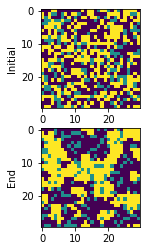

In [14]:
plot_states(c.initial_sl, sl_final) 